### Set up library


In [2]:
%%capture
!pip install nlpaug
!pip install nltk>=3.4.5

In [59]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.sparse import issparse
import re
from scipy.sparse import hstack
from scipy import sparse
from scipy.sparse import csr_matrix

import nlpaug.augmenter.word as naw

import nltk
from tqdm import trange
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger_eng')

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB, BernoulliNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score, f1_score, recall_score, ConfusionMatrixDisplay, confusion_matrix
from sklearn.feature_selection import SelectKBest, chi2

from imblearn.over_sampling import SMOTE

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!


### load dataset

In [4]:
df = pd.read_parquet("hf://datasets/tdavidson/hate_speech_offensive/data/train-00000-of-00001.parquet")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


### preprocessing

In [5]:
def clean(sample):
    sample = sample.lower()
    sample = re.sub(r'@\w+', '', sample)
    sample = re.sub('[^a-z A-Z 0-9-]+', '', sample)
    sample = " ".join([word for word in sample.split() if word not in stopwords.words('english') and word != 'rt'])

    return sample

In [6]:
df['tweet'] = df['tweet'].apply(lambda x : clean(x))

In [7]:
X = df.drop(columns='class')
y = df['class']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify = df['class'])

In [8]:
del X, y

Handling imbalanced dataset
- augmenting the minority classes
- oversampling
- SMOTE


Augmenting

- Replace synonyms in samples from class 0 and 2

In [9]:
def augmenting_data(row):
    aug = naw.SynonymAug(aug_src='wordnet')
    augmented_list = aug.augment(row['tweet'])
    row['tweet'] = augmented_list[0]  # Lấy bản đầu tiên
    return row

In [10]:
X_train = pd.concat([X_train, y_train], axis=1)
augmented_data = X_train[(X_train['class'] == 0) | (X_train['class'] == 2)].copy()
augmented_data.shape

(4474, 6)

In [11]:
augmented_tweet = augmented_data.apply(augmenting_data, axis=1)
X_train = pd.concat([X_train, augmented_tweet])

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


In [12]:
del augmented_tweet, augmented_data

Oversampling

- Randomly selecting 1200 samples from class 0

In [13]:
oversampling_data = X_train[X_train['class'] == 0].copy()
oversampling_data.shape

(2288, 6)

In [14]:
sampled_data = oversampling_data.sample(n=1200, random_state=42)
X_train = pd.concat([X_train, sampled_data])

In [15]:
X_train['class'].value_counts()

,count
class,
1,15352
2,6660
0,3488


In [16]:
del oversampling_data, sampled_data

Tf-idf vetorization

In [17]:
tweets = X_train['tweet'].values

vectorizer = TfidfVectorizer()

X_train_tfidf = vectorizer.fit_transform(tweets)

In [18]:
y_train = X_train['class']
X_train = X_train.drop(columns=['tweet', 'class'])

X_train = sparse.csr_matrix(X_train)
X_train = hstack([X_train, X_train_tfidf])

In [19]:
del X_train_tfidf, tweets

In [20]:
X_test_numeric = X_test.drop(columns=['tweet'])

X_test_numeric_sparse = sparse.csr_matrix(X_test_numeric.values)

X_test_tfidf = vectorizer.transform(X_test['tweet'])

X_test = hstack([X_test_numeric_sparse, X_test_tfidf])


In [21]:
del X_test_numeric, X_test_numeric_sparse, X_test_tfidf

SMOTE

In [22]:
sampling_strategy = {0: 5000, 2: 8000}
smote = SMOTE(sampling_strategy=sampling_strategy, random_state=42)

X_train, y_train = smote.fit_resample(X_train, y_train)

Feature selection

- choose top 1000 best features

In [23]:
selector = SelectKBest(chi2, k=1000)
X_train = selector.fit_transform(X_train, y_train)

In [24]:
X_test = selector.transform(X_test)

### Training

#### Logistic Regression

Manual Logistic regression

In [25]:
class MyLogisticRegression:
    def __init__(self, lr=0.001, n_iters=1000):
        self.lr = lr
        self.n_iters = n_iters

    def softmax(self, x):
        x = x - np.max(x, axis=1, keepdims=True)
        exp_x = np.exp(x)
        return exp_x / np.sum(exp_x, axis=1, keepdims=True)

    def Loss(self, y, y_pred):
        eps = 1e-15
        y_pred = np.clip(y_pred, eps, 1 - eps)
        return -np.mean(np.sum(y * np.log(y_pred), axis=1))

    def _one_hot(self, y):
        n_classes = np.max(y) + 1
        y_encoded = np.zeros((y.shape[0], n_classes))
        y_encoded[np.arange(y.shape[0]), y] = 1
        return y_encoded

    def fit(self, X, y):
        if len(y.shape) == 1 or y.shape[1] == 1:
            y = self._one_hot(y)

        n_samples, n_features = X.shape
        n_classes = y.shape[1]

        self.weights = np.zeros((n_features, n_classes))
        self.bias = np.zeros(n_classes)

        for i in range(self.n_iters):
            if issparse(X):
                linear_pred = X.dot(self.weights) + self.bias
            else:
                linear_pred = np.dot(X, self.weights) + self.bias

            soft = self.softmax(linear_pred)
            loss = self.Loss(y, soft)

            if i % 100 == 0 or i == self.n_iters - 1:
                print(f"Loss at iteration {i}: {loss:.4f}")

            error = soft - y

            if issparse(X):
                dw = (1 / n_samples) * X.T.dot(error)
            else:
                dw = (1 / n_samples) * np.dot(X.T, error)

            db = (1 / n_samples) * np.sum(error, axis=0)

            self.weights -= self.lr * dw
            self.bias -= self.lr * db

    def predict(self, X):
        if issparse(X):
            linear_pred = X.dot(self.weights) + self.bias
        else:
            linear_pred = np.dot(X, self.weights) + self.bias

        soft = self.softmax(linear_pred)
        return np.argmax(soft, axis=1)


In [26]:
lr = MyLogisticRegression()
lr.fit(X_train, y_train)

lr.predict(X_test)

Loss at iteration 0: 1.0986
Loss at iteration 100: 0.8930
Loss at iteration 200: 0.7781
Loss at iteration 300: 0.6984
Loss at iteration 400: 0.6365
Loss at iteration 500: 0.5858
Loss at iteration 600: 0.5432
Loss at iteration 700: 0.5066
Loss at iteration 800: 0.4747
Loss at iteration 900: 0.4467
Loss at iteration 999: 0.4222


array([1, 2, 1, ..., 1, 1, 1])

In [29]:
print(f'Precision: {precision_score(y_test, lr.predict(X_test), average="micro")}')
print(f'Recall: {recall_score(y_test, lr.predict(X_test), average="micro")}')
print(f'F1: {f1_score(y_test, lr.predict(X_test), average="micro")}')

Precision: 0.9529957635666734
Recall: 0.9529957635666734
F1: 0.9529957635666734


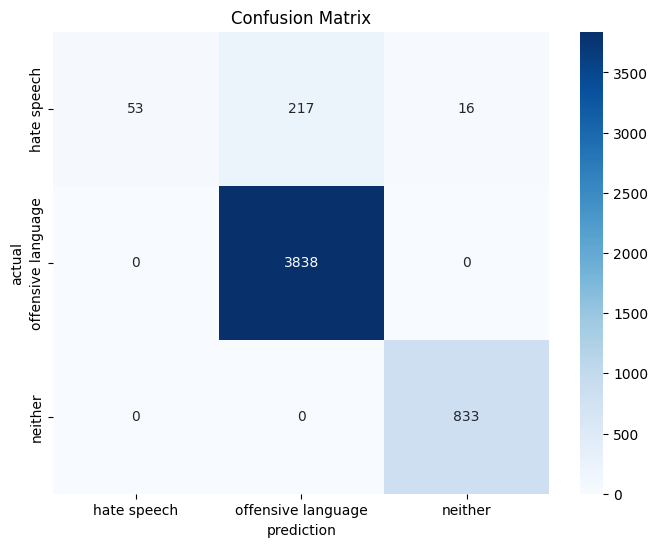

In [33]:
cm = confusion_matrix(y_test, lr.predict(X_test))
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['hate speech', 'offensive language', 'neither'],
            yticklabels=['hate speech', 'offensive language', 'neither'])

plt.xlabel('prediction')
plt.ylabel('actual')
plt.title('Confusion Matrix')
plt.show()

sklearn LR

Precision: 1.0
Recall: 1.0
F1: 1.0


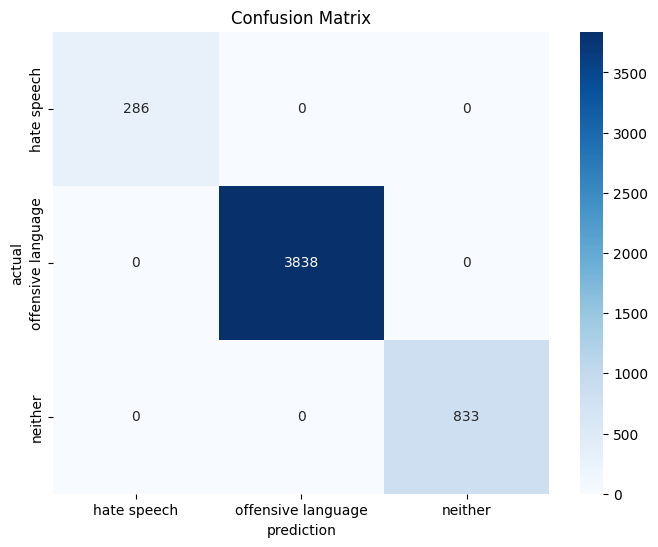

In [35]:
model = LogisticRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

print(f'Precision: {precision_score(y_test, y_pred, average="micro")}')
print(f'Recall: {recall_score(y_test, y_pred, average="micro")}')
print(f'F1: {f1_score(y_test, y_pred, average="micro")}')
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['hate speech', 'offensive language', 'neither'],
            yticklabels=['hate speech', 'offensive language', 'neither'])

plt.xlabel('prediction')
plt.ylabel('actual')
plt.title('Confusion Matrix')
plt.show()

#### Naive Bayes

Manual MultinomialNB

In [50]:
class MyMultinomialNB:
    def __init__(self, alpha=1.0):
        self.alpha = alpha

    def fit(self, X, y):
        # Kiểm tra X có phải là sparse matrix không
        if not isinstance(X, csr_matrix):
            X = csr_matrix(X)

        n_samples, n_features = X.shape
        self._classes = np.unique(y)
        n_classes = len(self._classes)

        # --- Tính toán các tham số ---
        # Khởi tạo mảng để lưu số đếm
        # feature_counts_: đếm số lần xuất hiện của mỗi từ trong mỗi lớp
        # class_counts_: đếm tổng số từ trong mỗi lớp
        self._feature_counts = np.zeros((n_classes, n_features), dtype=np.float64)
        self._class_counts = np.zeros(n_classes, dtype=np.float64)

        # Tính xác suất tiên nghiệm
        self._priors = np.zeros(n_classes, dtype=np.float64)

        for idx, c in enumerate(self._classes):
            # Lấy ra các hàng (văn bản) thuộc lớp c. Thao tác này hiệu quả với sparse matrix.
            X_c = X[y == c]

            # Đếm số lần xuất hiện của mỗi từ trong lớp c.
            # X_c.sum(axis=0) là phép toán được tối ưu cho sparse matrix.
            # np.asarray(...).flatten() để chuyển kết quả về mảng 1D.
            self._feature_counts[idx, :] = np.asarray(X_c.sum(axis=0)).flatten()

            # Đếm tổng số từ trong lớp c
            self._class_counts[idx] = self._feature_counts[idx, :].sum()

            # Tính xác suất tiên nghiệm
            self._priors[idx] = X_c.shape[0] / float(n_samples)

        # --- Tính toán khả năng hợp lý (likelihood) ---
        # P(word | class) = (word_count_in_class + alpha) / (total_words_in_class + alpha * n_features)
        numerator = self._feature_counts + self.alpha
        denominator = self._class_counts[:, np.newaxis] + self.alpha * n_features

        self._likelihoods = numerator / denominator

        # Lưu lại dưới dạng log để tính toán ở bước dự đoán nhanh và ổn định hơn
        self._log_priors = np.log(self._priors)
        self._log_likelihoods = np.log(self._likelihoods)


    def predict(self, X):
        if not isinstance(X, csr_matrix):
            X = csr_matrix(X)

        # Sử dụng list comprehension để lặp qua từng hàng của sparse matrix
        return [self._predict_single(x) for x in X]

    def _predict_single(self, x):
        posteriors = []

        for idx, c in enumerate(self._classes):
            log_prior_c = self._log_priors[idx]

            # Lấy các likelihood tương ứng với các từ có trong văn bản x
            # x.indices chứa chỉ số cột (index của từ) của các giá trị khác 0
            # x.data chứa giá trị (số đếm) của các từ đó
            feature_log_likelihoods = self._log_likelihoods[idx, x.indices]

            # Tính tổng log-likelihood, nhân với số đếm của từ
            # Đây là phần quan trọng nhất: chỉ tính toán trên các từ có xuất hiện
            log_likelihood_c = (feature_log_likelihoods * x.data).sum()

            posterior = log_prior_c + log_likelihood_c
            posteriors.append(posterior)

        return self._classes[np.argmax(posteriors)]

In [51]:
    nb = MyMultinomialNB()
    nb.fit(X_train, y_train.values)

    y_pred = nb.predict(X_test)

Precision: 0.995158361912447
Recall: 0.995158361912447
F1: 0.995158361912447


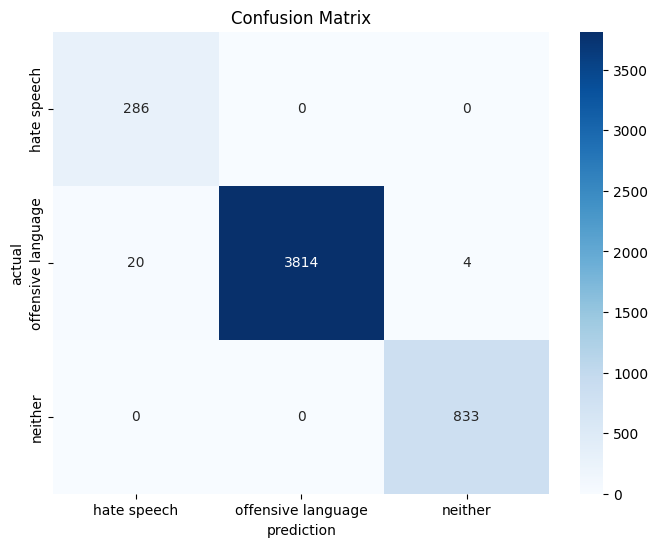

In [52]:
print(f'Precision: {precision_score(y_test, y_pred, average="micro")}')
print(f'Recall: {recall_score(y_test, y_pred, average="micro")}')
print(f'F1: {f1_score(y_test, y_pred, average="micro")}')
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['hate speech', 'offensive language', 'neither'],
            yticklabels=['hate speech', 'offensive language', 'neither'])

plt.xlabel('prediction')
plt.ylabel('actual')
plt.title('Confusion Matrix')
plt.show()

sklearn MultinomialNB

In [53]:
nb_model = MultinomialNB()
nb_model.fit(X_train, y_train)

y_pred = nb_model.predict(X_test)

Precision: 0.995158361912447
Recall: 0.995158361912447
F1: 0.995158361912447


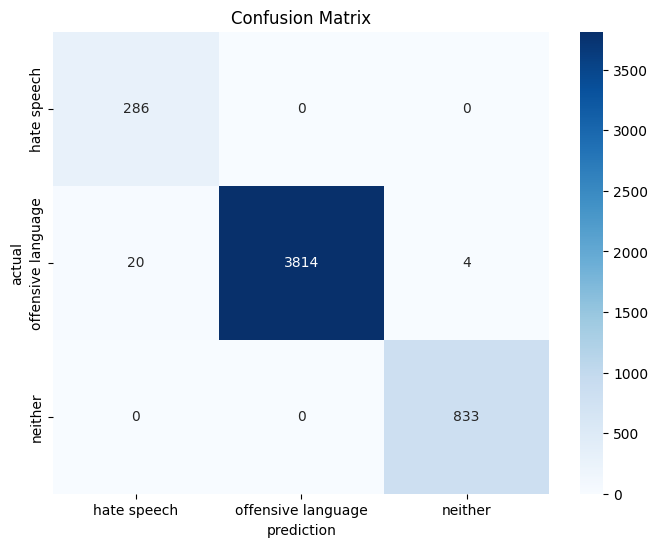

In [54]:
print(f'Precision: {precision_score(y_test, y_pred, average="micro")}')
print(f'Recall: {recall_score(y_test, y_pred, average="micro")}')
print(f'F1: {f1_score(y_test, y_pred, average="micro")}')
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['hate speech', 'offensive language', 'neither'],
            yticklabels=['hate speech', 'offensive language', 'neither'])

plt.xlabel('prediction')
plt.ylabel('actual')
plt.title('Confusion Matrix')
plt.show()

Manual BernoulliNB

In [55]:
class MyBernoulliNB:
    def __init__(self, alpha=1.0):
        self.alpha = alpha

    def fit(self, X, y):
        if not isinstance(X, csr_matrix):
            X = csr_matrix(X)

        # Bước 1: Binarize dữ liệu - Chuyển đổi ma trận đếm thành ma trận hiện diện (0 hoặc 1)
        # Nếu một giá trị > 0, nó trở thành 1.
        X = (X > 0).astype(int)

        n_samples, n_features = X.shape
        self._classes = np.unique(y)
        n_classes = len(self._classes)

        # Khởi tạo các biến
        self._priors = np.zeros(n_classes, dtype=np.float64)
        self._likelihoods = np.zeros((n_classes, n_features), dtype=np.float64)

        for idx, c in enumerate(self._classes):
            X_c = X[y == c]
            n_class_samples = X_c.shape[0]

            # 2. Tính xác suất tiên nghiệm (Prior)
            self._priors[idx] = n_class_samples / float(n_samples)

            # 3. Tính khả năng hợp lý (Likelihood)
            # P(word|c) = (số văn bản trong lớp c chứa word + alpha) / (tổng số văn bản trong lớp c + 2*alpha)
            feature_counts_in_class = np.asarray(X_c.sum(axis=0)).flatten()
            self._likelihoods[idx, :] = (feature_counts_in_class + self.alpha) / (n_class_samples + 2 * self.alpha)

        # Lưu lại dưới dạng log để tính toán nhanh hơn
        self._log_priors = np.log(self._priors)
        self._log_likelihoods = np.log(self._likelihoods)
        # Cũng cần log của (1 - likelihood) cho các từ không xuất hiện
        self._log_neg_likelihoods = np.log(1 - self._likelihoods)


    def predict(self, X):
        if not isinstance(X, csr_matrix):
            X = csr_matrix(X)

        # Binarize dữ liệu kiểm thử
        X = (X > 0).astype(int)

        return [self._predict_single(x) for x in X]

    def _predict_single(self, x):
        posteriors = []

        for idx, c in enumerate(self._classes):
            log_prior_c = self._log_priors[idx]

            # --- Đây là phần khác biệt chính so với Multinomial ---
            # Bắt đầu với giả định tất cả các từ trong từ vựng đều không xuất hiện
            log_likelihood_c = np.sum(self._log_neg_likelihoods[idx, :])

            # Bây giờ, chỉ cập nhật cho những từ thực sự có xuất hiện trong văn bản x
            # Đối với mỗi từ có mặt, ta trừ đi log(P(word_i=0|c)) và cộng vào log(P(word_i=1|c))
            present_features_indices = x.indices
            log_likelihood_c -= np.sum(self._log_neg_likelihoods[idx, present_features_indices])
            log_likelihood_c += np.sum(self._log_likelihoods[idx, present_features_indices])

            posterior = log_prior_c + log_likelihood_c
            posteriors.append(posterior)

        return self._classes[np.argmax(posteriors)]

In [57]:
model = MyBernoulliNB()
model.fit(X_train, y_train.values)

y_pred = model.predict(X_test)

Precision: 0.9193060318741174
Recall: 0.9193060318741174
F1: 0.9193060318741174


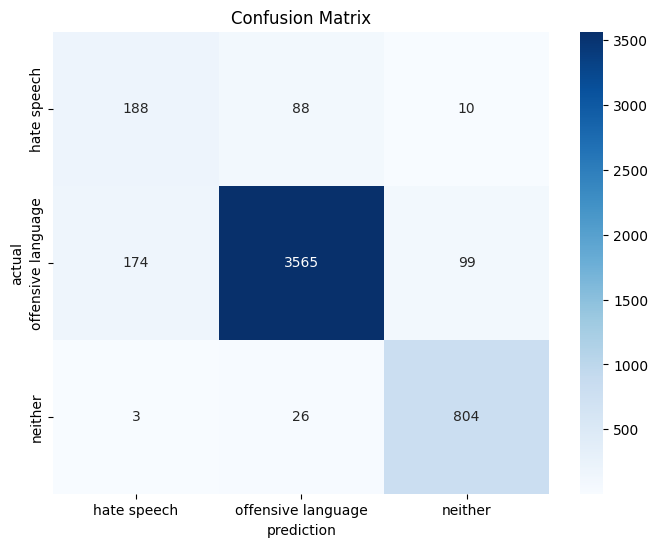

In [58]:
print(f'Precision: {precision_score(y_test, y_pred, average="micro")}')
print(f'Recall: {recall_score(y_test, y_pred, average="micro")}')
print(f'F1: {f1_score(y_test, y_pred, average="micro")}')
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['hate speech', 'offensive language', 'neither'],
            yticklabels=['hate speech', 'offensive language', 'neither'])

plt.xlabel('prediction')
plt.ylabel('actual')
plt.title('Confusion Matrix')
plt.show()

sklearn BernoulliNB

In [60]:
model = BernoulliNB()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

Precision: 0.9193060318741174
Recall: 0.9193060318741174
F1: 0.9193060318741174


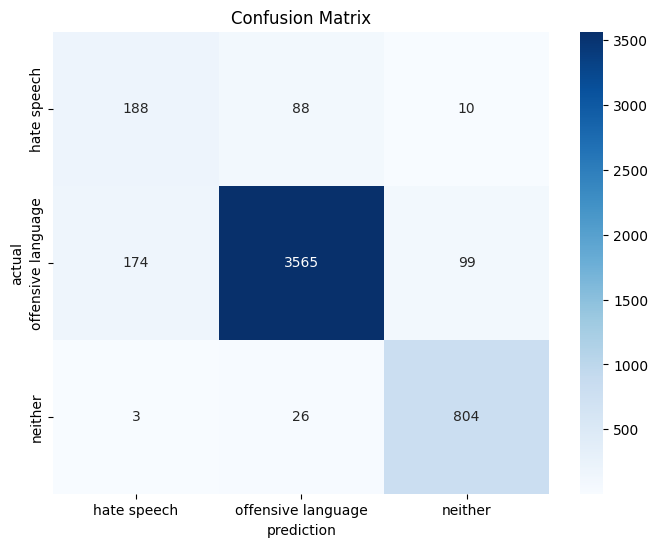

In [61]:
print(f'Precision: {precision_score(y_test, y_pred, average="micro")}')
print(f'Recall: {recall_score(y_test, y_pred, average="micro")}')
print(f'F1: {f1_score(y_test, y_pred, average="micro")}')
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['hate speech', 'offensive language', 'neither'],
            yticklabels=['hate speech', 'offensive language', 'neither'])

plt.xlabel('prediction')
plt.ylabel('actual')
plt.title('Confusion Matrix')
plt.show()